# Some Moire effects
This is designed to show you how your eye sees grids and stuff.

In [14]:
import cv2 as cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import shutil

%matplotlib inline

Here are some useful functions for colour conversion, because I like to work in an awkward colour space.

In [2]:
def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y

# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]    
    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta))
    b = y + 1.773 * (u-delta)   
    
    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    
    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def quantiseUV(data, width, height):
    numLevels = 16
    q = 256/numLevels
    x = np.linspace(0, 10, 1000)
    
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    u = q * np.round(u/q)
    v = q * np.round(v/q)

    yuv = np.concatenate((y,u,v), axis = 0)
    return yuv

#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    
    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )
    
    return yuv

def RGB2YUV(img):
    width = img.shape[1]
    height = img.shape[0]
    img_ = np.transpose(img,(2,1,0))
    yuv = planarRGB_2_planarYUV(img_, width, height)
    yuv = yuv.reshape((3, width, height))
    #yuv = 255-yuv
    return yuv

def YUV2RGB(yuv):
    width = yuv.shape[1]
    height = yuv.shape[2]
    rgb = planarYUV_2_planarRGB(yuv, width, height)
    rgb = rgb.reshape((3, width, height))
    rgb = np.transpose(rgb, (2,1,0))
    return rgb

def showYUV(imgY):
    image = YUV2RGB(imgY)
    plt.imshow(image, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
def showOneYChannel(Y):
    U = np.full((Y.shape[0], Y.shape[1]), 128)
    V = np.full((Y.shape[0], Y.shape[1]), 128)
    YUV = np.zeros((3, Y.shape[0], Y.shape[1]))
    YUV[0, :, :] = Y
    YUV[1, :, :] = U
    YUV[2, :, :] = V
    image = YUV2RGB(YUV)

    plt.imshow(image, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def saveOneYChannel(Y, name):
    U = np.full((Y.shape[0], Y.shape[1]), 128)
    V = np.full((Y.shape[0], Y.shape[1]), 128)
    YUV = np.zeros((3, Y.shape[0], Y.shape[1]))
    YUV[0, :, :] = Y
    YUV[1, :, :] = U
    YUV[2, :, :] = V
    image = YUV2RGB(YUV)
    cv2.imwrite(name, image)




Let's set up some global dimensions.

In [3]:
width = 352
height = 352

And now we create a grid. First, it's just a vertical/horizontal grid which is double the dimensions of what we need. We're going to apply an affine transform and then crop out the centre part of the image so that we get a nice, even grid all over the image.

In [5]:
gridSpacing = 16
gridAngle = 10
white = 255
black = 0
lineThickness = 2
start_w = width//2
start_h = height//2
end_w = start_w + width
end_h = start_h + height

grid = np.zeros((width*2, height*2))

for i in range(0, width*2):
    for j in range(0, height*2):
        if (i % gridSpacing) in range(0,lineThickness):
            grid[i, j] = 1
        if (j % gridSpacing) in range(0,lineThickness):
            grid[i, j] = 1
                
#print(grid)
gridOrig = np.copy(grid)
grid1 = np.copy(grid[start_w:end_w, start_h:end_h])
grid1[grid1 != 0] = white

# Rotate the grid:
M = cv2.getRotationMatrix2D((height,width),gridAngle,1)
grid = cv2.warpAffine(grid,M,(height*2, width*2))

grid = grid[start_w:end_w, start_h:end_h]
grid[grid != 0] = white
grid2 = np.copy(grid)

print(grid.shape)
        

(352, 352)


So, now we have two grids of spacing `gridSpacing` and angle `gridAngle`.

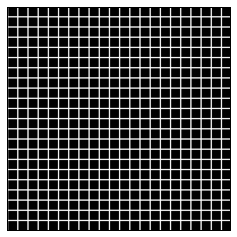

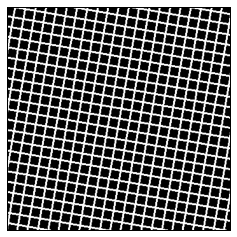

In [6]:
showOneYChannel(grid1)
showOneYChannel(grid2)

add the images together using opencv

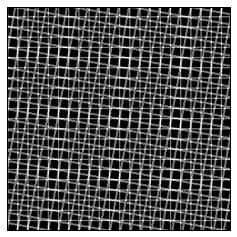

In [7]:
alpha = 0.5
beta = 1 - alpha

moire = cv2.addWeighted(grid1,alpha,grid2,beta,0)
showOneYChannel(moire)

In [16]:
def rotateGrid(grid, width, height, gridAngle):
    # Rotate the grid:
    M = cv2.getRotationMatrix2D((height,width),gridAngle,1)
    grid = cv2.warpAffine(grid,M,(height*2, width*2))
    start_w = width//2
    start_h = height//2
    end_w = start_w + width
    end_h = start_h + height
    grid = grid[start_w:end_w, start_h:end_h]
    grid[grid != 0] = white
    return grid


imageList = []
gifName = "moire.gif"
pngTextList = ""
pngDirName = "temp_png"
os.makedirs(pngDirName)
for i, angle in enumerate(range(0, 60, 5)):
    newGrid = rotateGrid(gridOrig, width, height, angle)
    moire = cv2.addWeighted(grid1,alpha,newGrid,beta,0)
    name = "{}/moire{}.png".format(pngDirName, i)
    saveOneYChannel(moire, name)
    imageList.append(name)
    pngTextList = "{} {}".format(pngTextList, name)

os.system('convert {} {}'.format(pngTextList, gifName))
if os.path.isdir(pngDirName):
    shutil.rmtree(pngDirName)
    

# And here is the end gif showing a moire pattern:
![Here's the gif'](moire.gif)